In [159]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepnlp/Sheet_2.csv
/kaggle/input/deepnlp/Sheet_1.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt


In [160]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
stop_words = stopwords.words('english')

In [205]:
df = pd.read_csv('../input/deepnlp/Sheet_1.csv')
colnames = ['response_text', 'response_id', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']

# Collapse response columns into response_text
df['response_text'] = df['response_text'].astype('str')
df[colnames[0]] += df[colnames[2:7]].fillna('').sum(1)
df = df.drop(columns=colnames[1:7])

df['class'].value_counts()

not_flagged    55
flagged        25
Name: class, dtype: int64

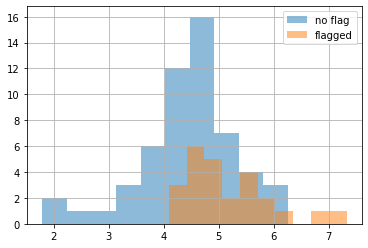

In [206]:
# label encoding
df['class'] = preprocessing.LabelEncoder().fit_transform(df['class'])

xtrain, xvalid, ytrain, yvalid = \
        train_test_split(df['response_text'], df['class'], random_state=1)

# df['class'].value_counts()  # flagged is '0'

# Plot some distribution
df.loc[df['class'] == 1, 'response_text'].str.len().apply(np.log1p).hist(label='no flag', alpha=.5)
df.loc[df['class'] == 0, 'response_text'].str.len().apply(np.log1p).hist(label='flagged', alpha=.5)
plt.legend(); # we can see flagged responses tend to be longer

In [203]:
# Using pre trained word vectors eg GloVe, word2vec, fasttext

# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

2196018it [05:40, 6456.26it/s]
 10%|█         | 2/20 [00:00<00:00, 2658.83it/s]

Found 2195893 word vectors.


In [213]:
# Create sentence vectors using the above function for training and validation set
# tqdm is a loading bar lol
from tqdm import tqdm
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

# convert sentence vectors to array
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)

#Fit and predict using XGBoost
clf.fit(xtrain_glove, ytrain)
preds_train = clf.predict(xtrain_glove)
preds_valid = clf.predict(xvalid_glove)

print('Train acc:', accuracy_score(ytrain, preds_train)) # 1.0
print('Val acc:', accuracy_score(yvalid, preds_valid)) # 0.95

100%|██████████| 20/20 [00:00<00:00, 1129.78it/s]


[16:11:34] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train acc: 1.0
Val acc: 0.95


In [257]:
# Deep Learning 
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

# we need to binarize the labels -- run to_categorical twice 
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

# Create 3 layer sequential neural net for starters
model = Sequential()

model.add(Dense(3000, input_dim=300, activation='relu')) #300 because used 300d GloVe
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1600, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(2))              # Set to num of classes
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# fit the model
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))
# train loss: 0.01, val loss: 0.19 

Train on 60 samples, validate on 20 samples
Epoch 1/5
60/60 [==============================] - 1s 9ms/step - loss: 1.1948 - val_loss: 0.3641
Epoch 2/5
60/60 [==============================] - 0s 1ms/step - loss: 0.5618 - val_loss: 0.2599
Epoch 3/5
60/60 [==============================] - 0s 1ms/step - loss: 0.0431 - val_loss: 0.2202
Epoch 4/5
60/60 [==============================] - 0s 981us/step - loss: 0.0379 - val_loss: 0.2004
Epoch 5/5
60/60 [==============================] - 0s 993us/step - loss: 0.0134 - val_loss: 0.1932


In [258]:
# Try LSTM model, but tokenize the text data first
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 678/678 [00:00<00:00, 106570.91it/s]


In [276]:
# Simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.6, recurrent_dropout=0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(xtrain_pad, y=ytrain_enc, epochs=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

# Val loss 0.55 ... how to adjust hyperparameters? Hmm... read up more

Train on 60 samples, validate on 20 samples
Epoch 1/20
60/60 [==============================] - 1s 11ms/step - loss: 0.6852 - val_loss: 0.6157
Epoch 2/20
60/60 [==============================] - 0s 2ms/step - loss: 0.6451 - val_loss: 0.5776
Epoch 3/20
60/60 [==============================] - 0s 2ms/step - loss: 0.6142 - val_loss: 0.5645
Epoch 4/20
60/60 [==============================] - 0s 2ms/step - loss: 0.6240 - val_loss: 0.5574
Epoch 5/20
60/60 [==============================] - 0s 2ms/step - loss: 0.5748 - val_loss: 0.5493
Epoch 6/20
60/60 [==============================] - 0s 2ms/step - loss: 0.5734 - val_loss: 0.5425
Epoch 7/20
60/60 [==============================] - 0s 2ms/step - loss: 0.5488 - val_loss: 0.5409
Epoch 8/20
60/60 [==============================] - 0s 2ms/step - loss: 0.5034 - val_loss: 0.5354
Epoch 9/20
60/60 [==============================] - 0s 2ms/step - loss: 0.4475 - val_loss: 0.5311
Epoch 10/20
60/60 [==============================] - 0s 2ms/step - loss: 